# MACS 30100
### Ling Dai

In [1]:
#import libraries

import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#import data
strongdrink = pd.read_csv('strongdrink.txt', header = 0)
strongdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## 1(a)

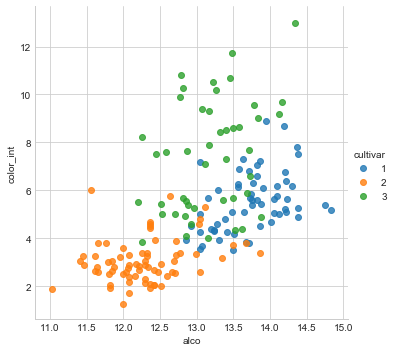

In [3]:
g = sb.lmplot('alco','color_int', fit_reg=False, data=strongdrink, hue = 'cultivar')

## 1(b)

In [4]:
import statsmodels.api as sm

X = sm.add_constant(strongdrink[['alco', 'malic', 'tot_phen', 'color_int']])
y = strongdrink['cultivar']

/Users/lingdai/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR

kf_mlog = KFold(n_splits=4, shuffle=True, random_state=22)
penalty_list = []
C_list = []
MSE_list = []

for penalty in ['l1', 'l2']:
    for C in np.arange(0.1,10,0.01):
        for train, test in kf_mlog.split(X):
            X_train = X.iloc[train]
            y_train = y.iloc[train]
            X_test = X.iloc[test]
            y_test = y.iloc[test]
            reg = LR(multi_class='multinomial',solver='saga',
                     penalty = 'l1',C = C).fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            penalty_list.append(penalty)
            C_list.append(C)
            MSE_list.append(((y_test - y_pred) ** 2).mean())

MSE_df = pd.DataFrame({'penalty':penalty_list,
                       'C':C_list,
                       'MSE':MSE_list})

MSE_df = MSE_df.sort_values(by=['MSE'])
MSE_df.head()

/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,C,MSE,penalty
7320,8.50,0.068182,l2
7308,8.47,0.068182,l2
2440,6.20,0.068182,l1
2444,6.21,0.068182,l1
5536,4.04,0.068182,l2


Because only 'saga' solver supports both 'l1' and 'l2' penalty among all multinomial solvers, I used 'saga' as the solver in 1(b). I tested both 'l1' and 'l2' for penalty, and all values from 0.1 to 10 (with step size = 0.1) for C. A minimun MSE of 0.068182 was achieved by several models wit different combinations of parameters: penalty = 'l2', C = 6.94; penalty = 'l2', C = 6.37; penalty = 'l1', C = 4.54; penalty = 'l1', C = 8.75, penalty = 'l1', C = 4.55.

## 1(c)

In [6]:
Xvals = strongdrink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = strongdrink['cultivar'].values

In [7]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = []
min_samples_leaf_list = []
max_depth_list = []
MSE_list = []

for n_estimators in range(50,300,50):
    for min_samples_leaf in range(5,16):
        for max_depth in range(1,6):
            RF = RandomForestClassifier(n_estimators = n_estimators,
                                        min_samples_leaf = min_samples_leaf,
                                        max_depth = max_depth, bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(Xvals, yvals)
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            min_samples_leaf_list.append(min_samples_leaf)
            MSE_list.append(1 - RF.oob_score_)

MSE_df = pd.DataFrame({'n_estimator':n_estimators_list,
                       'max_depth':max_depth_list,
                       'min_samples_leaf':min_samples_leaf_list,
                       'MSE':MSE_list})

MSE_df = MSE_df.sort_values(by=['MSE'])
MSE_df.head()

,MSE,max_depth,min_samples_leaf,n_estimator
239,0.068182,5,8,250
92,0.068182,3,12,100
197,0.068182,3,11,200
68,0.068182,4,7,100
87,0.068182,3,11,100


For random forest classifier, I tried all values between 50 and 300 (step size = 50) for n_estimators, all values from 5 to 15 (step size = 1) for min_samples_leaf, and all values from 1 to 5 (step size = 1) for depth. A minimun MSE of 0.068182 was achieved by several models wit different combinations of parameters: max_depth = 5, min_samples_leaf = 8, n_estimator = 250; max_depth = 3, min_samples_leaf = 12, n_estimator = 100; max_depth = 3, min_samples_leaf = 11, n_estimator = 200; max_depth = 3, min_samples_leaf = 11, n_estimator = 100...

## 1(d)

In [8]:
from sklearn.svm import SVC

gamma_list = []
cost_list = []
MSE_list = []

for gamma in np.arange(0.05,2.05,0.05):
    for cost in np.arange(0.25,5.25,0.25):
        for train, test in kf_mlog.split(X):
            X_train = X.iloc[train]
            y_train = y.iloc[train]
            X_test = X.iloc[test]
            y_test = y.iloc[test]
            svc = SVC(kernel='rbf', gamma = gamma, C=C)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            gamma_list.append(gamma)
            cost_list.append(cost)
            MSE_list.append(((y_test - y_pred) ** 2).mean())

MSE_df = pd.DataFrame({'gamma':gamma_list,
                       'cost':cost_list,
                       'MSE':MSE_list})

MSE_df = MSE_df.sort_values(by=['MSE'])
MSE_df.head()

,MSE,cost,gamma
0,0.045455,0.25,0.05
2740,0.045455,1.50,1.75
2744,0.045455,1.75,1.75
2748,0.045455,2.00,1.75
2752,0.045455,2.25,1.75


For random SVC, I tried all values between 0.05 and 2.0 (step size = 0.05) for gamma, all values from 0.25 to 5.0 (step size = 0.25) for cost. A minimun MSE of 0.068182 was achieved by several models wit different combinations of parameters: gamma = 1.75, cost = 1.50; gamma = 1.75, cost = 1.75; gamma = 1.75, cost = 2.00; gamma = 1.75, cost = 2.25...

## 1(e)

In [9]:
from sklearn.neural_network import MLPClassifier

alpha_list = []
hidden_layer_sizes_list = []
MSE_list = []
activation_list = []

for activation in ['identity', 'logistic', 'tanh', 'relu']:
    for alpha in np.arange(0.05,1.05,0.05):
        for hidden_layer_sizes in range(50,550,50):
            for train, test in kf_mlog.split(X):
                X_train = X.iloc[train]
                y_train = y.iloc[train]
                X_test = X.iloc[test]
                y_test = y.iloc[test]
                mlp = MLPClassifier(activation=activation, solver='lbfgs',
                                    alpha=alpha, hidden_layer_sizes = hidden_layer_sizes)
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                activation_list.append(activation)
                alpha_list.append(alpha)
                hidden_layer_sizes_list.append(hidden_layer_sizes)
                MSE_list.append(((y_test - y_pred) ** 2).mean())

MSE_df = pd.DataFrame({'activation':activation_list,
                       'alpha':alpha_list,
                       'hidden_layer_sizes':hidden_layer_sizes_list,
                       'MSE':MSE_list})

MSE_df = MSE_df.sort_values(by=['MSE'])
MSE_df.head()

,MSE,activation,alpha,hidden_layer_sizes
1788,0.0,tanh,0.25,400
2540,0.0,relu,0.20,300
2668,0.0,relu,0.35,400
3100,0.0,relu,0.90,300
2792,0.0,relu,0.50,450


For MLP, I tried four different kinds of activation functions, namely 'identity', 'logistic', 'tanh', and 'relu'. I also tested all values from 0.05 to 1.0 (step size = 0.05) for alpha, and all values from 50 to 500 (step size = 50). A minimun MSE of 0 was achieved by several models wit different combinations of parameters: alpha = 0.20, activation = 'relu', hidden_layer_sizes = 400; alpha = 0.20, activation = 'relu', hidden_layer_sizes = 350...

## 1(f)

According to the minimun test MSE achieved by the models above, the MLP classifier was the best predictor of cultivar, because several MLP model with different combinations of parameter settings achieved MSE of 0.0, which means all the predictions were correct for these models. The second best predictor in this case is SVM, with a minimun MSE of 0.0045455. Multinomial logistic regression and random forest seemed to have similar accuracy on predicting cultivar: both of them had a minimun MSE of 0.068182.

However, we can't complete rule out the possibility that the lower MSEs achieved by MLP classifier and SVM were in part due to the choice of step sizes.